### Data wrangle

In [197]:
# Grab Data
import yfinance as yf

# Usual Suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Use PyPortfolioOpt for Calculations
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import DiscreteAllocation

In [198]:
# Create a Portfolio
symbols = ['PFE','GSK','AZN','BMY','MRK','RHHBY','SNY','NVS','ABBV','JNJ']

In [199]:
# Get the stock data
portfolio = yf.download(symbols, start="2000-01-01", end="2024-02-29")['Adj Close']
portfolio.head()

[*********************100%%**********************]  10 of 10 completed


Ticker,ABBV,AZN,BMY,GSK,JNJ,MRK,NVS,PFE,RHHBY,SNY
Date,,,,,,,,,,
2000-01-03,NaN,8.473518,25.552814,18.336882,24.698620,26.873907,15.261843,13.061064,NaN,NaN
2000-01-04,NaN,8.190206,23.619623,17.862457,23.794405,25.930071,14.973387,12.574479,NaN,NaN
2000-01-05,NaN,8.228839,23.468321,18.460632,24.045578,26.948412,15.038945,12.779361,NaN,NaN
2000-01-06,NaN,8.203083,23.791838,18.192484,24.799099,27.171938,15.366734,13.240343,NaN,NaN
2000-01-07,NaN,8.550782,27.275999,19.141298,25.854021,29.779858,15.602740,14.136685,NaN,NaN


In [200]:
# SP500 ETF Benchmark
market_prices = yf.download("SPY", start="2000-01-01", end="2024-02-29")["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


Date
2000-01-03    93.881935
2000-01-04    90.210556
2000-01-05    90.371971
2000-01-06    88.919525
2000-01-07    94.083641
Name: Adj Close, dtype: float64

In [201]:
# Grap Market Capitalization for each stock in portfolio
mcaps = {}
for t in symbols:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'PFE': 153705349120,
 'GSK': 88431386624,
 'AZN': 206177271808,
 'BMY': 108773597184,
 'MRK': 312781045760,
 'RHHBY': 218156679168,
 'SNY': 120486043648,
 'NVS': 205854261248,
 'ABBV': 315933163520,
 'JNJ': 384247005184}

### Setting up priors

In [202]:
# Calculate Sigma and Delta to get implied market returns
# Ledoit-Wolf is a particular form of shrinkage, where the shrinkage coefficient is computed using O?
S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()

delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

1.801497502241776

<Axes: xlabel='Ticker', ylabel='Ticker'>

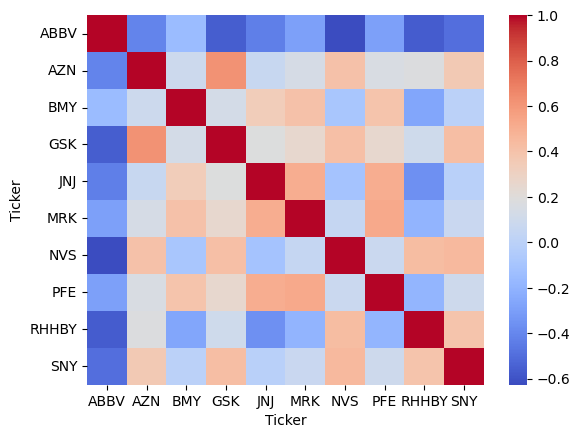

In [203]:
# Visualize the Covariant Correlation
sns.heatmap(S.corr(), cmap='coolwarm')

In [204]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

Ticker
ABBV     0.043932
AZN      0.070439
BMY      0.065990
GSK      0.063695
JNJ      0.059346
MRK      0.074377
NVS      0.059459
PFE      0.069051
RHHBY    0.054350
SNY      0.065266
dtype: float64

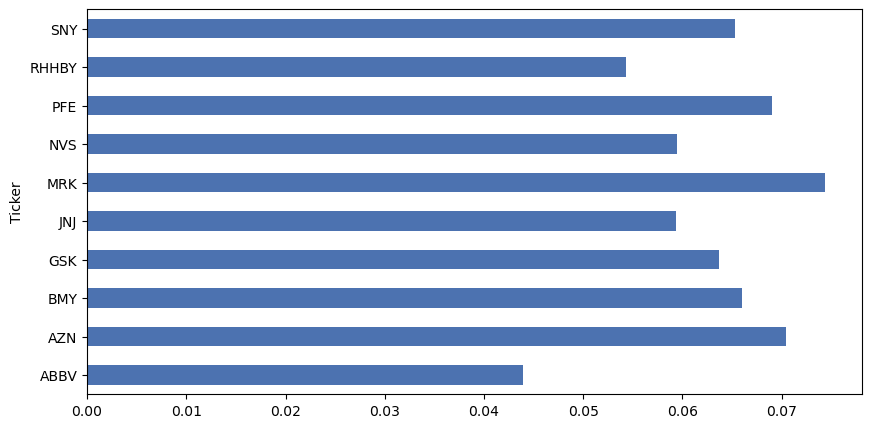

In [205]:
# What am I looking at here?
market_prior.plot.barh(figsize=(10,5));

### Integrating views

In [206]:
#You don't have to provide views on all the assets
viewdict = {'PFE': 0.1,
            'GSK': 0.1,
            'AZN': -0.05,
            'BMY': 0.28,
            'MRK': 0.09,
            'RHHBY': -0.12,
            'SNY': 0.07,
            'NVS': -0.25,
            'ABBV': 0.21,
            'JNJ': 0.2}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

#### Creating confidences

We can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [207]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.03, 0.1),
    (-0.1, 0),
    (0.1, 0.2),
    (-0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [208]:
variances = []
for lb, ub in intervals: # lb: lower bound, ub: upper bound
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0012250000000000002, 0.0025000000000000005, 0.0025000000000000005, 0.010000000000000002, 0.16000000000000003, 0.0225]


### Calculate Posterior Estimate Returns

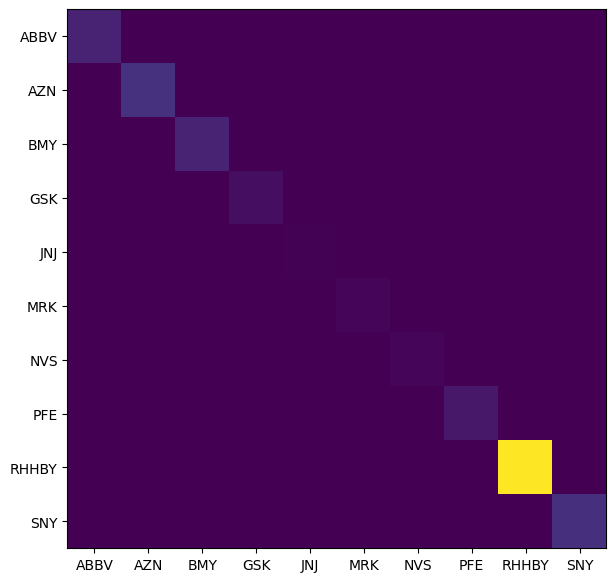

In [209]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [210]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [211]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

Ticker
ABBV     0.028787
AZN      0.033119
BMY      0.125343
GSK      0.042524
JNJ      0.057619
MRK      0.083668
NVS     -0.002392
PFE      0.069639
RHHBY   -0.031741
SNY      0.043805
dtype: float64

In [212]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
ABBV,0.043932,0.028787,0.21
AZN,0.070439,0.033119,-0.05
BMY,0.065990,0.125343,0.28
GSK,0.063695,0.042524,0.10
JNJ,0.059346,0.057619,0.20
MRK,0.074377,0.083668,0.09
NVS,0.059459,-0.002392,-0.25
PFE,0.069051,0.069639,0.10
RHHBY,0.054350,-0.031741,-0.12
SNY,0.065266,0.043805,0.07


<Axes: >

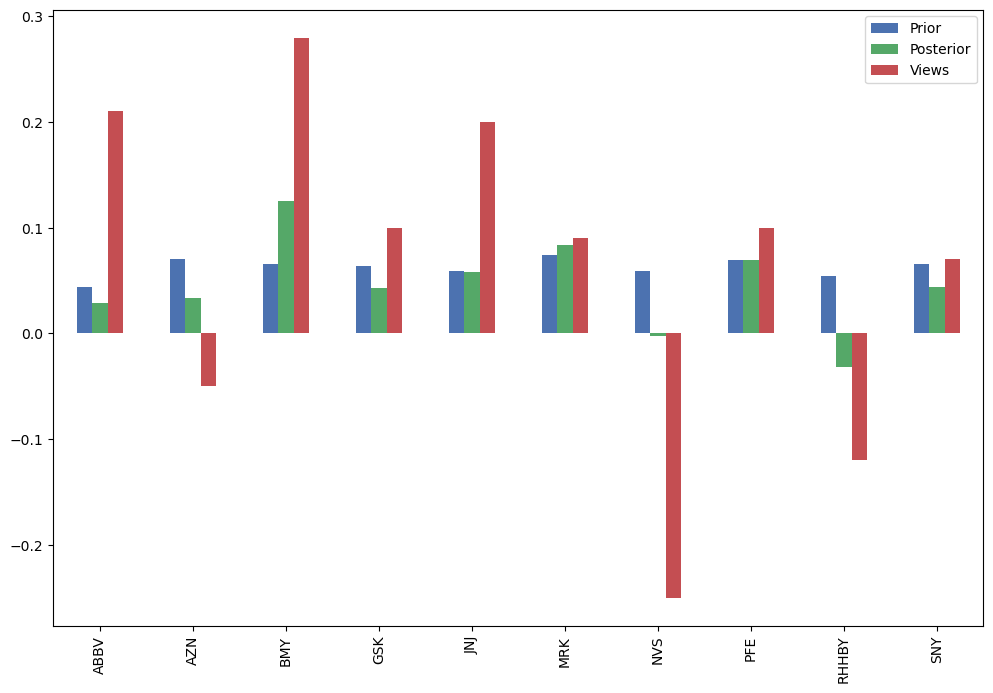

In [213]:
rets_df.plot.bar(figsize=(12,8))

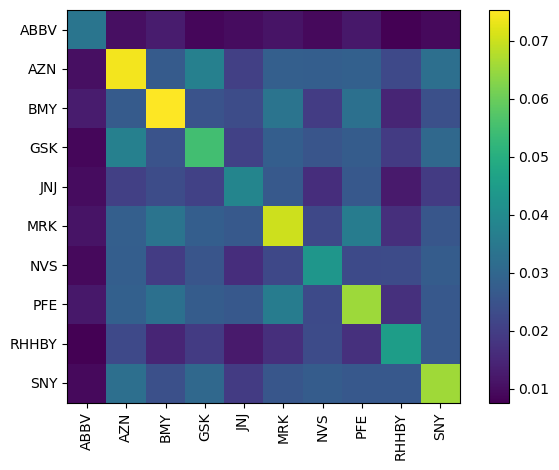

In [214]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

### Portfolio allocation

In [215]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

c:\Users\JoyChang\anaconda3\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('ABBV', 0.02167),
             ('AZN', 0.02194),
             ('BMY', 0.35744),
             ('GSK', 0.05866),
             ('JNJ', 0.11849),
             ('MRK', 0.20432),
             ('NVS', 0.0),
             ('PFE', 0.15352),
             ('RHHBY', 0.0),
             ('SNY', 0.06398)])

<Axes: >

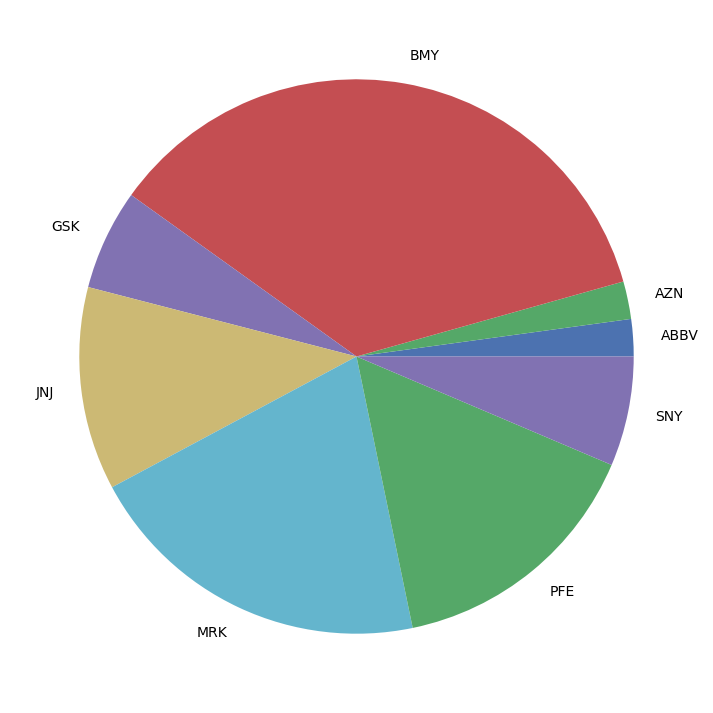

In [216]:
pd.Series(weights).plot.pie(figsize=(9,9))

Expected annual return: 8.6%
Annual volatility: 19.3%
Sharpe Ratio: 0.34


c:\Users\JoyChang\anaconda3\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
c:\Users\JoyChang\anaconda3\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.086062142572, 0.19251741420440996, 0.34314891899522887)

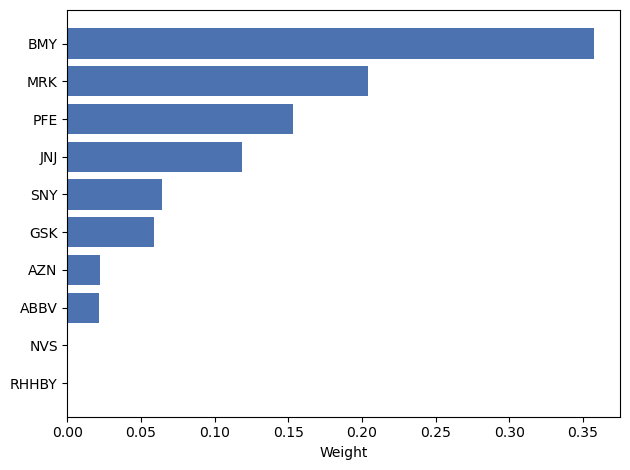

In [217]:
from pypfopt.plotting import plot_weights

# Maximum Sharpe
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()

plot_weights(weights)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.009)